In [9]:
import numpy
from matplotlib import colors
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import minimize
import pandas as pd

In [10]:
# Register the color map to be used for plotting.
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

In [11]:
# Read the data from the problem 3 file.
from numpy import genfromtxt
my_data = genfromtxt('logistic_regression.csv', delimiter=',', skip_header=1)
print(my_data.shape)
X = my_data[:, [0, 1]]
y = my_data[:, 2]

# Divide the data into two classes for plotting.
X0 = my_data[numpy.where(my_data[:, 2] == 0)]
X1 = my_data[numpy.where(my_data[:, 2] == 1)]

(2000, 3)


In [12]:
# Implements the natural log of the logistic function on $w^T x$.
def log_logistic_prob(iterate, x):
    t = numpy.dot(iterate[1:], x) + iterate[0]
    if t < -33:
        return t
    elif t < -18:
        return t - numpy.exp(t)
    elif t < 37:
        return -numpy.log1p(numpy.exp(- t ))
    else:
        return -numpy.exp(-t)

# Implements the logistic function on $w^T x$.
def logistic_prob(iterate, x):
    t = numpy.dot(iterate[1:], x) + iterate[0]
    if t < -33.3:
        return numpy.exp(t)
    elif t <= -18:
        return numpy.exp(t - numpy.exp(t))
    elif t <= 37:
        return numpy.exp(-numpy.log1p(numpy.exp(-t)))
    else:
        return numpy.exp(-numpy.exp(-t))

In [13]:
# Evaluates the logistic function on a set of grid points.
def logistic_prob_grid(iterate, grids):
    return numpy.array([logistic_prob(iterate, x) for x in grids ])

# Takes the logistic probability and thresholds to outputs a classification label.
def logistic_pred(iterate, x):
    return 1.0 if logistic_prob(iterate, x) > 0.5 else 0.0

In [23]:
# Implements the negative logistic regression objective. Modify me!
def negative_log_likelihood(iterate, X, y, regularization):
        
    # The accumulated objective value.
    obj_val = 0.0
    
        
    # Loop over each (x, y) pair.
    for i, (x_vec, y) in enumerate(zip(X, y)):
            
        # Dot product $w^T x$.            
        predict = iterate[0] + numpy.dot(iterate[1:], x_vec)
            
        # Accumulate the objective value contribution from this (x, y) pair.
        obj_val += (- (1 - y) * predict + log_logistic_prob(iterate, x_vec) )
        
    # Subtract the regularization parameter.
    #return - obj_val + regularization * numpy.dot(iterate[1:], iterate[1:])
    return -obj_val + numpy.dot(regularization*iterate[1:], iterate[1:])

In [24]:
# Implements the logistic regression gradient. Modify me!
def gradient_negative_log_likelihood(iterate, X, y, regularization):
    gradient = numpy.zeros(3)
    
    # Loop over each (x, y) pair. 
    for i, (x_vec, y) in enumerate(zip(X, y)):
        
        # Dot product $w^T x$.            
        predict = iterate[0] + numpy.dot(iterate[1:], x_vec)
        
        if predict > 0.0:
            factor = ((y - 1) + y * numpy.exp(-predict)) / ( 1 + numpy.exp(-predict) )
        else:
            factor = ((y - 1) * numpy.exp(predict) + y ) / ( 1 + numpy.exp(predict) )
        gradient[0] -= factor
        gradient[1:] -= factor * x_vec
        
    # Regularize gradient.
    gradient[1:] += 2 * regularization * iterate[1:]
    
    return gradient

In [25]:
# Plots the data with the decision boundary.
def plot_data(X, y, iterate, regularization):
    y_pred = [logistic_pred(iterate, x) for x in X]
    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 200
    x_min, x_max = (-10, 10)
    y_min, y_max = (-10, 10)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    xx, yy = numpy.meshgrid(numpy.linspace(x_min, x_max, nx),
                         numpy.linspace(y_min, y_max, ny))
   
    Z = logistic_prob_grid(iterate, numpy.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    neg_log_likelihood = negative_log_likelihood(iterate, X, y, regularization)
    plt.title(
        'Negative log likelihood: ' + str(neg_log_likelihood))
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    
    # Plot my linear decision boundary here!
    linex = numpy.linspace(x_min, x_max, nx)
    liney = -iterate[0]/iterate[2]-iterate[1]/iterate[2]*linex
    plt.plot(linex, liney, c = 'white')

    
    
    plt.show()

In [26]:
# Plot for each different regularization value by calling your optimization routine for
# different values.

No Regularization

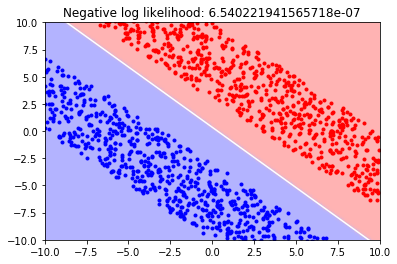

In [32]:
res0 = minimize(
    negative_log_likelihood, 
    [0,0,0], method = 'BFGS',
    jac = gradient_negative_log_likelihood, 
    args=(X,y,numpy.array([0,0]),))
plot_data(X,y,res0.x,0)#lambda=0 no regularization

regularize on $w_1$ with $\lambda=[10^0, 10^1, 10^2, 10^3, 10^4, 10^5]$

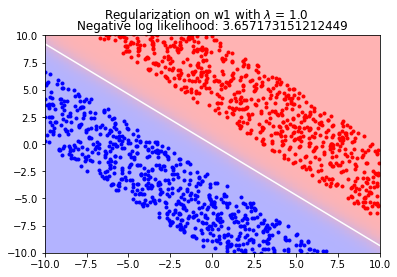

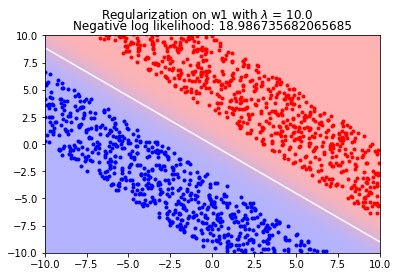

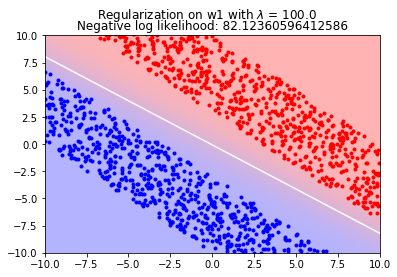

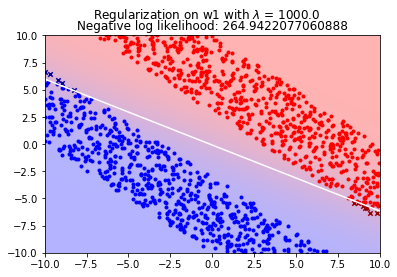

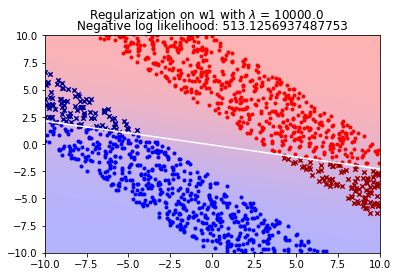

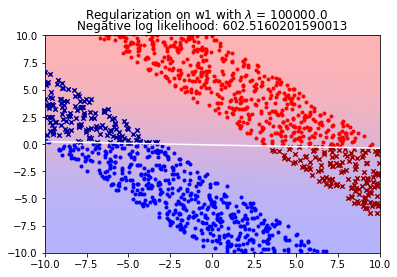

In [51]:
lambda_grid_w1 = numpy.logspace(0,5,6)
for i in range(6):
    regularization = lambda_grid_w1[i]
    res1 = minimize(negative_log_likelihood,[0,0,0],
                    method = 'BFGS',
                    jac = gradient_negative_log_likelihood, 
                    args=(X,y,numpy.array([regularization,0])))
    plt.suptitle('Regularization on w1 with $\lambda$ = '+ str(regularization))
    plot_data(X,y,res1.x,numpy.array([regularization,0]))
    

regularize on $w_2$ with $\lambda=[10^3, 10^4, 10^5, 10^6, 10^7, 10^8]$

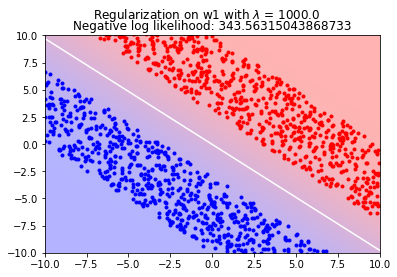

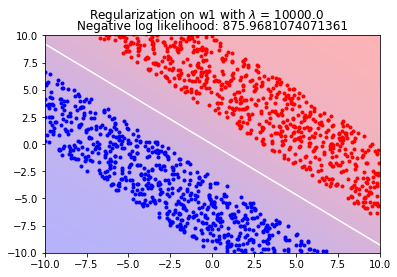

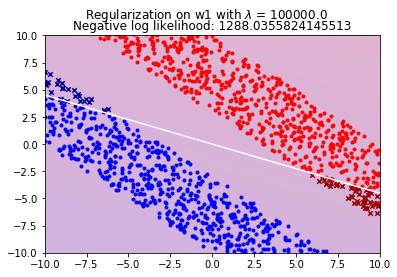

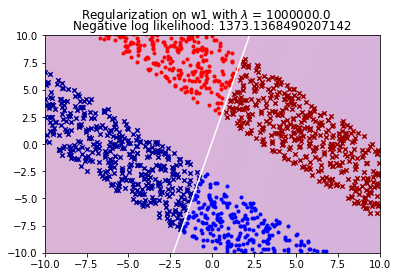

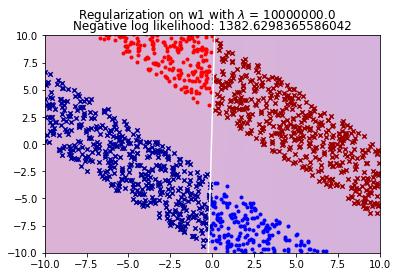

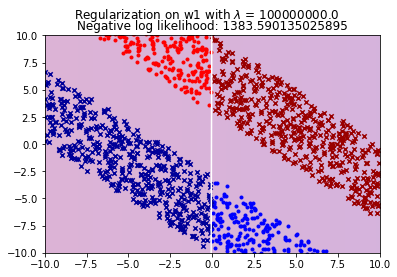

In [52]:
lambda_grid_w2 = numpy.logspace(3, 8, 6)
for i in range(6):
    regularization = lambda_grid_w2[i]
    res2 = minimize(negative_log_likelihood,[0,0,0],
                    method = 'BFGS',
                    jac = gradient_negative_log_likelihood, 
                    args=(X,y,numpy.array([1,regularization])))
    plt.suptitle('Regularization on w1 with $\lambda$ = '+ str(regularization))
    plot_data(X,y,res2.x,numpy.array([1,regularization]))
    

### observation:
- if we do not regularize on the logistic regression, the decision boundary would perfectly separate the two classes with no training error.

- if we regularize on $w_1$, the training error increses as $\lambda$ goes larger (penalize more on $w_1$). Eventually the decision boundary will be a horizontal line as parameter $w_1=0$.

- if we regularize on $w_2$, as $\lambda$ increases, the decision boundary becomes a vertical line as $w_2=0$.

- in both cases of regularization, training error increases as we penealize more on parameters.